In [2]:
os.chdir('c:\\Users\\chkla\\Documents\\GitHub\\DMC20_abraca-data\\DMC20_abraca-data\data')

In [3]:
os.getcwd()

'c:\\Users\\chkla\\Documents\\GitHub\\DMC20_abraca-data\\DMC20_abraca-data\\data'

In [4]:
import pandas as pd

df_train = pd.read_csv('orders0206_train.csv', sep='|', parse_dates=['time'])
df_test = pd.read_csv('orders0206_train.csv', sep='|', parse_dates=['time'])

df_info = pd.read_csv('infos.csv', sep='|', index_col='itemID')
product_prices = df_info['simulationPrice'].to_dict()
df_train["time"] = pd.to_datetime(df_train["time"], format='%Y-%m-%d %H:%M:%S')

df_items = pd.read_csv('items.csv', sep='|', index_col='itemID')


df_train_joined = df_train.join(df_info, on='itemID').join(df_items, on='itemID')

In [5]:
df_train.head()

,time,transactID,itemID,order,salesPrice
0,2018-01-01 00:01:56,2278968,450,1,17.42
1,2018-01-01 00:01:56,2278968,83,1,5.19
2,2018-01-01 00:07:11,2255797,7851,2,20.47
3,2018-01-01 00:09:24,2278968,450,1,17.42
4,2018-01-01 00:09:24,2278968,83,1,5.19


In [6]:
#create column only containing date
df_train['date'] = df_train['time'].dt.date
df_train.head()

,time,transactID,itemID,order,salesPrice,date
0,2018-01-01 00:01:56,2278968,450,1,17.42,2018-01-01
1,2018-01-01 00:01:56,2278968,83,1,5.19,2018-01-01
2,2018-01-01 00:07:11,2255797,7851,2,20.47,2018-01-01
3,2018-01-01 00:09:24,2278968,450,1,17.42,2018-01-01
4,2018-01-01 00:09:24,2278968,83,1,5.19,2018-01-01


In [7]:
#add up all orders that were made on one day
df_train['sum_sold'] = df_train['order'].groupby(df_train['date']).transform('sum')
df_train.head()

,time,transactID,itemID,order,salesPrice,date,sum_sold
0,2018-01-01 00:01:56,2278968,450,1,17.42,2018-01-01,6305
1,2018-01-01 00:01:56,2278968,83,1,5.19,2018-01-01,6305
2,2018-01-01 00:07:11,2255797,7851,2,20.47,2018-01-01,6305
3,2018-01-01 00:09:24,2278968,450,1,17.42,2018-01-01,6305
4,2018-01-01 00:09:24,2278968,83,1,5.19,2018-01-01,6305


In [8]:
#limit data to relevant variables only -> sum_sold and date
seasonal = df_train[["sum_sold", "date"]]
#remove duplicates
df_duplicates_removed = seasonal.drop_duplicates(subset=['sum_sold', 'date'])
df_duplicates_removed.head()
#date to datetime format ?error message?
df_duplicates_removed['date'] = pd.to_datetime(df_duplicates_removed['date'])

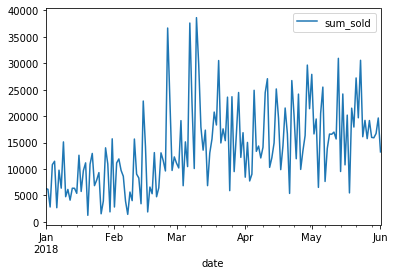

In [9]:
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import ExponentialSmoothing, SimpleExpSmoothing, Holt

#use line plot to visually inspect data for seasonality 
df_duplicates_removed.plot.line(x = 'date', 
             y = 'sum_sold')
plt.show()

#we definetly see a general upward trend

we definetly see a general upward trend

**What kind of seasonalities are relevant for us?**
-Time of Day -> not really relevant if we forecast for a two week period
-Day of the week -> not really relevant if we forecast for a two week period
-Weekly -> relevant
-Monthly -> relevant
-Yearly -> not enough data

**How do we know that an effect is seasonal if we only have data for half a year(periodicity is unknown)?**
**Do we want to correct for seasonality?(No)**


In [10]:
#average number of sold items per day -> 14090,026
df_duplicates_removed.loc[:,"sum_sold"].mean()

#average number of sold items per week

#average number of sold items per month

14090.026315789473

In [11]:
#checking for seasonality in terms of festivities (only those in all parts of Germany):
df_duplicates_removed.loc[df_duplicates_removed['date'] == '2018-01-01']
#new years sold: 6305

df_duplicates_removed.loc[df_duplicates_removed['date'] == '2018-03-30']
#easter friday 12196 items sold

df_duplicates_removed.loc[df_duplicates_removed['date'] == '2018-04-02']
#easter monday 15026 items sold

df_duplicates_removed.loc[df_duplicates_removed['date'] == '2018-05-01']
#labor day 27885 items sold

df_duplicates_removed.loc[df_duplicates_removed['date'] == '2018-05-10']
#'christi Himmelfahrt' 16567

df_duplicates_removed.loc[df_duplicates_removed['date'] == '2018-05-21']
#pfingsten 27206



,sum_sold,date
1540637,27206,2018-05-21


In [12]:
#exponential smoothing seems to be a thing we could do, note that this doesnt refer to seasonality but to trend
#gives error message
#model = ExponentialSmoothing(df_duplicates_removed, trend="add", seasonal="add", seasonal_periods=6)

In [13]:
df_items = pd.read_csv('items.csv', sep='|', index_col='itemID')
df_train_joined = df_train.join(df_info, on='itemID').join(df_items, on='itemID')

In [14]:
df_categories = df_train_joined.drop(['transactID','salesPrice','recommendedRetailPrice','customerRating','simulationPrice','sum_sold','time','promotion','category2','category3','manufacturer','brand','itemID'], axis=1)
df_categories.head()

,order,date,category1
0,1,2018-01-01,1
1,1,2018-01-01,1
2,2,2018-01-01,4
3,1,2018-01-01,1
4,1,2018-01-01,1


In [15]:
df_categories.pivot( columns='category1',values='order')

category1,1,2,3,4,5,6,7,8
0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN
3,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
1727359,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
1727360,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
1727361,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
1727362,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN


In [16]:

#add up all orders that were made on one day


x = df_categories.groupby(['date','category1']).agg('sum')

x.head(20)


order
date       category1       
2018-01-01 1           2153
           2             12
           3             14
           4             84
           5            180
           6            714
           7           3132
           8             16
2018-01-02 1            553
           2             43
           3              7
           4           3496
           5           1715
           6             16
           7             74
           8            261
2018-01-03 1           1893
           2             41
           3             92
           4            126

In [17]:
x.unstack(level=1)

order                                            
category1      1      2     3     4      5     6     7     8
date                                                        
2018-01-01  2153     12    14    84    180   714  3132    16
2018-01-02   553     43     7  3496   1715    16    74   261
2018-01-03  1893     41    92   126     58    82   407   122
2018-01-04  1027     23  1147  1081    474  3632  2992   443
2018-01-05   320    898   315   168   7467    56  1921   320
...          ...    ...   ...   ...    ...   ...   ...   ...
2018-05-28   502    430   207   457   9267    51  4410   648
2018-05-29  1187   1471   124  8711    109    73   103  4122
2018-05-30    98  15956    20   180     90    66    75   218
2018-05-31  1144   2054    17  3378  12291    68   117   572
2018-06-01   169   2209  2094   334    156  3155  4538   576

[152 rows x 8 columns]

In [18]:
type(x)

pandas.core.frame.DataFrame

In [23]:
x[1].head()

KeyError: 1

In [63]:
df_categories_days = x.unstack(level=1)

In [64]:
df_categories_days

order                                            
category1      1      2     3     4      5     6     7     8
date                                                        
2018-01-01  2153     12    14    84    180   714  3132    16
2018-01-02   553     43     7  3496   1715    16    74   261
2018-01-03  1893     41    92   126     58    82   407   122
2018-01-04  1027     23  1147  1081    474  3632  2992   443
2018-01-05   320    898   315   168   7467    56  1921   320
...          ...    ...   ...   ...    ...   ...   ...   ...
2018-05-28   502    430   207   457   9267    51  4410   648
2018-05-29  1187   1471   124  8711    109    73   103  4122
2018-05-30    98  15956    20   180     90    66    75   218
2018-05-31  1144   2054    17  3378  12291    68   117   572
2018-06-01   169   2209  2094   334    156  3155  4538   576

[152 rows x 8 columns]